In [83]:
# import all the modules and libraries required

import os
import matplotlib.pyplot as plt
import tensorflow 

from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.models import Sequential,load_model
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, Dropout

from keras.utils import to_categorical
from keras.optimizers import Adam

import keras.backend as K

In [84]:
# log into Kaggle and download the dataset onto the Colab cloud filesystem

os.environ['KAGGLE_USERNAME'] = "mayurshegokar"
os.environ['KAGGLE_KEY'] = "89bb9b46e5b5fe4d6ed9f996b1bfa8d1"
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

chest-ctscan-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [85]:
# using ImageDataGenerator to increase input data by generating new data points from existing data

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range = 5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [86]:
# unzip the downloaded dataset from Kaggle

from zipfile import ZipFile

file_name = "/content/chest-ctscan-images.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('unzip success!')

unzip success!


In [87]:
# generate data for training, testing and validation by converting the images in the provided dataset into the target parameters

print('training dataset:')
train_dataset  = train_datagen.flow_from_directory(directory = '../content/Data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)
print('validation dataset: ')
valid_dataset = valid_datagen.flow_from_directory(directory = '../content/Data/valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)
print('testing sataset: ')
test_dataset = test_datagen.flow_from_directory(directory = '../content/Data/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

training dataset:
Found 613 images belonging to 4 classes.
validation dataset: 
Found 72 images belonging to 4 classes.
testing sataset: 
Found 315 images belonging to 4 classes.


In [88]:
# freeze the weights for base model layer i.e. VGG 

base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")
for layer in base_model.layers[:-8]:
    layer.trainable = False

In [89]:
# build the model for classification by adding more layers to the base model layer i.e. VGG

model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4, activation = 'softmax'))

In [90]:
# print a summary of the model built

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_20 (Bat  (None, 25088)            100352    
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 32)                802848    
                                                                 
 batch_normalization_21 (Bat  (None, 32)               128       
 chNormalization)                                     

In [91]:
# define some metrics to evaluate the model after training and testing

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision + recall + K.epsilon())
    return f1_val

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),  
      f1_score,
]

In [92]:
# compile the model using Adam as optimizer and loss function as categorical crossentropy

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)

In [98]:
# train the model by slicing the data into batches and repeatedly iterating over the provided dataset for epochs specified

history = model.fit(train_dataset,
                  validation_data = valid_dataset,
                  epochs = 15,
                  verbose = 1);

Epoch 1/15
10/10 [==============================] - 11s 1s/step - loss: 1.1637 - accuracy: 0.7806 - precision: 0.7451 - recall: 0.1860 - f1_score: 0.3021 - val_loss: 6.9506 - val_accuracy: 0.5938 - val_precision: 0.1831 - val_recall: 0.1806 - val_f1_score: 0.2116
Epoch 2/15
10/10 [==============================] - 10s 1s/step - loss: 1.1012 - accuracy: 0.7794 - precision: 0.7727 - recall: 0.1664 - f1_score: 0.2741 - val_loss: 5.4571 - val_accuracy: 0.5938 - val_precision: 0.1831 - val_recall: 0.1806 - val_f1_score: 0.1570
Epoch 3/15
10/10 [==============================] - 11s 1s/step - loss: 1.0823 - accuracy: 0.7904 - precision: 0.8367 - recall: 0.2007 - f1_score: 0.3248 - val_loss: 3.9114 - val_accuracy: 0.6181 - val_precision: 0.2031 - val_recall: 0.1806 - val_f1_score: 0.2167
Epoch 4/15
10/10 [==============================] - 10s 1s/step - loss: 1.0415 - accuracy: 0.7879 - precision: 0.7962 - recall: 0.2039 - f1_score: 0.3193 - val_loss: 161.3340 - val_accuracy: 0.5903 - val_prec

In [111]:
# evaluate the model on the testing dataset using metrics specified while compiling

values = model.evaluate(test_dataset, verbose = 1)
print('model accuracy: ', values[1] * 100, '%')
print('precision: ', values[2])
print('recall: ', values[3])
print('f1_score: ', values[4])
model.metrics_names

5/5 [==============================] - 2s 375ms/step - loss: 0.9884 - accuracy: 0.7833 - precision: 0.9773 - recall: 0.1365 - f1_score: 0.2348
model accuracy:  78.33333611488342 %
precision:  0.9772727489471436
recall:  0.13650794327259064
f1_score:  0.23480823636054993


['loss', 'accuracy', 'precision', 'recall', 'f1_score']

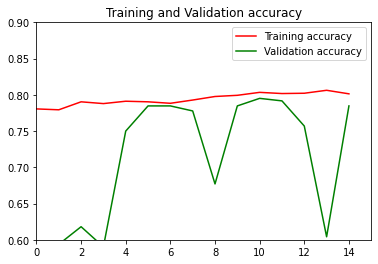

<Figure size 432x288 with 0 Axes>

In [106]:
# plot the accuracy for training and validation across epochs completed

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 0)
plt.ylim(0.6, 0.9)
plt.xlim(0, 15)
plt.figure()

plt.show()

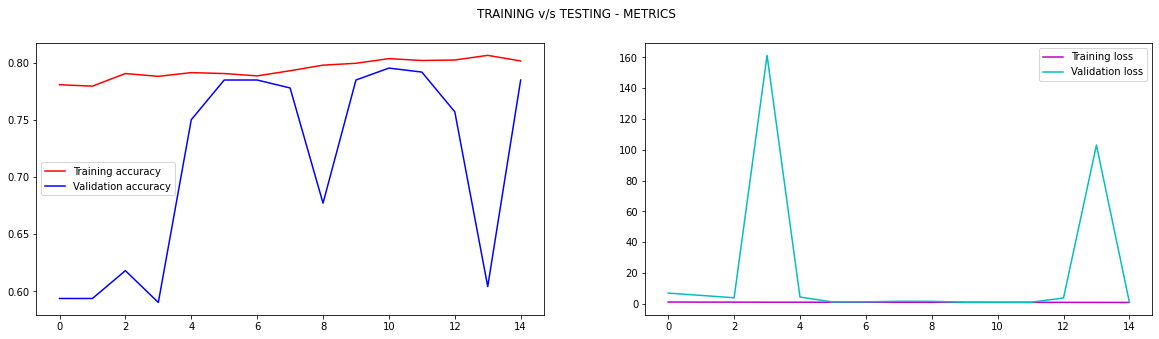

In [115]:
# plot the accuracy for training and validation across epochs completed

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, (plt1, plt2) = plt.subplots(1, 2, figsize= (20, 5))
fig.suptitle("TRAINING v/s TESTING - METRICS")

plt1.plot(epochs, acc, 'r', label='Training accuracy')
plt1.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt1.legend(loc = 0)

plt2.plot(epochs, loss, 'm', label='Training loss')
plt2.plot(epochs, val_loss, 'c', label='Validation loss')
plt2.legend(loc = 0)

plt.show()